<h2> NOT FINISHED YET </h2>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<h3> We can try to make the general DIB algorithm based on the geometric DIB algorithm </h3>

In [7]:
from functions_IB import kl_divergence, entropy, mutual_information
from functions_IB import generate_joint_distribution, information_bottleneck, IB_curve
from functions_IB import compute_mutual_information_over_beta
from functions_geom_DIB import DIB_curve, compute_entropy_over_beta

In [8]:
def general_DIB(p_xy, max_iter=100, beta=0.5):
    """
    Performs the general deterministic information bottleneck algorithm for clustering.

    Parameters:
    - p_xy (numpy.ndarray): The joint probability distribution of data points and clusters.
    - max_iter (int): The maximum number of iterations for the algorithm. Default is 100.
    - beta (float): The beta parameter for the algorithm. Default is 0.5.

    Returns:
    - q_t_given_x (numpy.ndarray): The conditional probability distribution of clusters given data points.
    - q_t (numpy.ndarray): The marginal probability distribution of clusters.
    - q_y_given_t (numpy.ndarray): The conditional probability distribution of data points given clusters.
    """
    num_data_points = p_xy.shape[0]
    num_clusters = p_xy.shape[0]
    
    # Initialize f(x) as if each index i is assigned to its own cluster
    f_x = np.arange(num_data_points)

    # Initialization 
    d_xt = np.zeros((num_data_points, num_clusters))
    p_y_given_x = p_xy / np.sum(p_xy, axis=1, keepdims=True)
    p_x = np.sum(p_xy, axis=1)
    
    # Initialize q(t) and q(y|t)
    q_t = np.zeros(num_clusters)
    q_y_given_t = np.zeros_like(p_xy)
    for t in range(num_clusters):
        relevant_indices = np.where(f_x == t)[0]
        if len(relevant_indices) > 0:
            q_t[t] = np.sum(p_x[relevant_indices])
            q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
    
    q_t /= np.sum(q_t)  # Normalize q(t)

    # Iterative algorithm
    for _ in range(max_iter):
        
        # Compute d, l_beta, and f
        for i in range(num_data_points):
            for j in range(num_clusters):
                d_xt[i, j] = kl_divergence(p_y_given_x[i], q_y_given_t[j])

        l_beta_xt = np.log(q_t) - beta * d_xt
        f_x = np.argmax(l_beta_xt, axis=1)
        
        # Update q_t_given_x
        q_t_given_x = np.eye(num_clusters)[f_x]
        
        # Update q_t and q_y_given_t
        for t in range(num_clusters):
            relevant_indices = np.where(f_x == t)[0]
            if len(relevant_indices) > 0:
                q_t[t] = np.sum(p_x[relevant_indices])
                q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
        
        # Normalize q(t)
        q_t /= np.sum(q_t)

########################################################################################################

        # Merge step to verify if we are stuck in a local minimum
        best_merge = None

        # Compute the objective function with the current clusters
        H_T = entropy(q_t)
        I_TY = mutual_information(q_t.reshape(-1, 1) * q_y_given_t)
        objective = H_T - beta * I_TY

        # Compute the objective function for each pair of consecutive clusters
        for i in range(num_clusters - 1):
            # Merge clusters i and i + 1
            merged_f_x = f_x.copy()
            merged_f_x[np.where(merged_f_x == i + 1)] = i

            # Initialize merge_q_t and merge_q_y_given_t
            merged_q_t = np.zeros(num_clusters)
            merged_q_y_given_t = np.zeros_like(p_xy)

            # Update merge_q_t and merge_q_y_given_t
            for t in range(num_clusters):
                relevant_indices = np.where(merged_f_x == t)[0]
                if len(relevant_indices) > 0:
                    merged_q_t[t] = np.sum(p_x[relevant_indices])
                    merged_q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
            
            # Compute the objective function with the merged clusters
            merged_H_T = entropy(merged_q_t)
            merged_I_TY = mutual_information(merged_q_t.reshape(-1, 1) * merged_q_y_given_t)
            merged_objective = merged_H_T - beta * merged_I_TY

            if merged_objective < objective:
                objective = merged_objective
                best_merge = i

        if best_merge is not None:
            # If the objective function can be improved, merge the clusters
            f_x[np.where(f_x == best_merge + 1)] = best_merge
            q_t_given_x = np.eye(num_clusters)[f_x]
        
            # Update q_t and q_y_given_t after the merge
            for t in range(num_clusters):
                relevant_indices = np.where(f_x == t)[0]
                if len(relevant_indices) > 0:
                    q_t[t] = np.sum(p_x[relevant_indices])
                    q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
            # Normalize q(t) 
            q_t /= np.sum(q_t)   

    return q_t_given_x, q_t, q_y_given_t

In [9]:
# Define the joint distribution of X and Y
joint_prob = generate_joint_distribution(5, 3)
joint_prob 

array([[0.01292908, 0.00596032, 0.00681807],
       [0.09420275, 0.12248163, 0.00018399],
       [0.16751816, 0.07144555, 0.06800112],
       [0.05892777, 0.07432685, 0.02748434],
       [0.04316548, 0.0927505 , 0.15380438]])

In [10]:
general_DIB(joint_prob, max_iter=100, beta=0.5)

(array([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]),
 array([1.58528012e-04, 1.33734313e-03, 9.95005762e-01, 9.91214798e-04,
        2.50715253e-03]),
 array([[0.50293097, 0.23185147, 0.26521756],
        [0.43437754, 0.56477404, 0.00084842],
        [0.37674325, 0.36696484, 0.2562919 ],
        [0.36660541, 0.46240719, 0.1709874 ],
        [0.14899016, 0.32013801, 0.53087183]]))

In [11]:
information_bottleneck(joint_prob, max_iter=100, beta=0.5)

(array([[0.22922065, 0.16092785, 0.13580802, 0.19437381, 0.27966966],
        [0.22922065, 0.16092785, 0.13580802, 0.19437381, 0.27966966],
        [0.22922065, 0.16092785, 0.13580802, 0.19437381, 0.27966966],
        [0.22922065, 0.16092785, 0.13580802, 0.19437381, 0.27966966],
        [0.22922065, 0.16092785, 0.13580802, 0.19437381, 0.27966966]]),
 array([0.22922065, 0.16092785, 0.13580802, 0.19437381, 0.27966966]),
 array([[0.37674325, 0.36696484, 0.2562919 ],
        [0.37674325, 0.36696484, 0.2562919 ],
        [0.37674325, 0.36696484, 0.2562919 ],
        [0.37674325, 0.36696484, 0.2562919 ],
        [0.37674325, 0.36696484, 0.2562919 ]]))

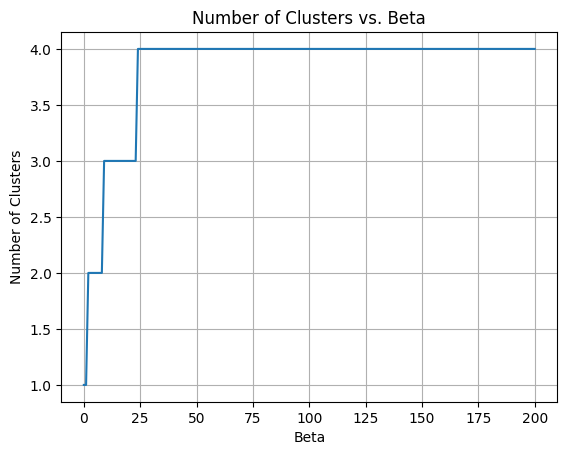

In [12]:
# Define a range of beta values
betas = np.linspace(0, 200, 201)

# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = general_DIB(joint_prob, max_iter=200, beta=beta)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

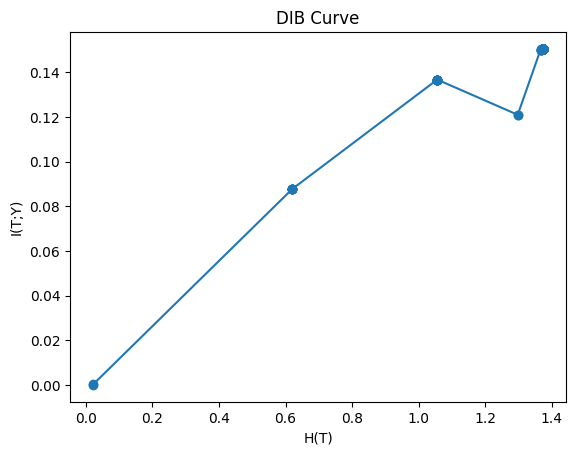

In [13]:
DIB_curve(joint_prob, beta_values=betas, max_iter=200)

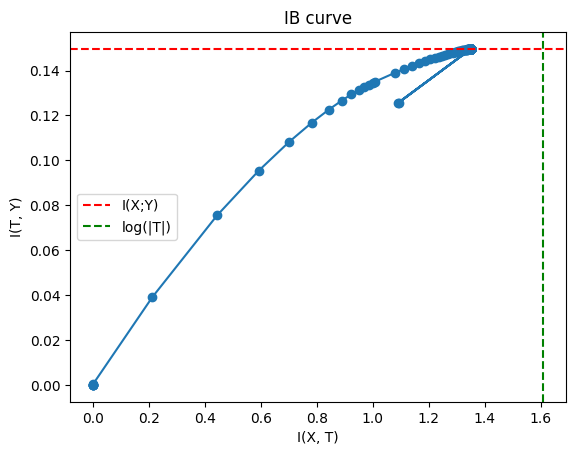

In [14]:
IB_curve(joint_prob, beta_values=betas, max_iter=200, algorithm=information_bottleneck)

In [17]:
betas = np.linspace(0, 200, 201)
I_XT_IB, I_TY_IB = compute_mutual_information_over_beta(joint_prob, beta_values=betas,
                                                   max_iter=100, algorithm=information_bottleneck)
I_XT_DIB, I_TY_DIB = compute_mutual_information_over_beta(joint_prob, beta_values=betas, 
                                                          max_iter=100, algorithm=general_DIB)
H_T_IB = compute_entropy_over_beta(joint_prob, beta_values=betas, max_iter=100, algorithm=information_bottleneck)
H_T_DIB = compute_entropy_over_beta(joint_prob, beta_values=betas, max_iter=100, algorithm=general_DIB)


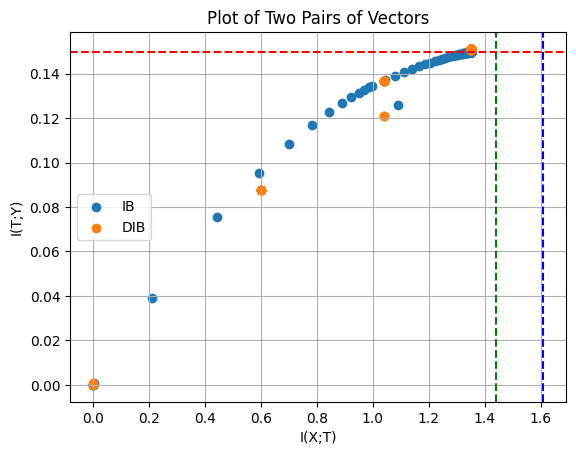

In [28]:
# Plot the first pair of vectors
plt.scatter(I_XT_IB, I_TY_IB, label='IB')

# Plot the second pair of vectors
plt.scatter(I_XT_DIB, I_TY_DIB, label='DIB')

# Add labels and title
plt.xlabel('I(X;T)')
plt.ylabel('I(T;Y)')
plt.title('Plot of Two Pairs of Vectors')

#Add horizontal line at I(X;Y)
I_XY = mutual_information(joint_prob)
plt.axhline(y=I_XY, color='r', linestyle='--')

# Add a vertical line at H(X) and log(|T|)
H_X = entropy(np.sum(joint_prob, axis=1))
log_T = np.log(joint_prob.shape[0])
plt.axvline(x=H_X, color='g', linestyle='--')
plt.axvline(x=log_T, color='b', linestyle='--')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

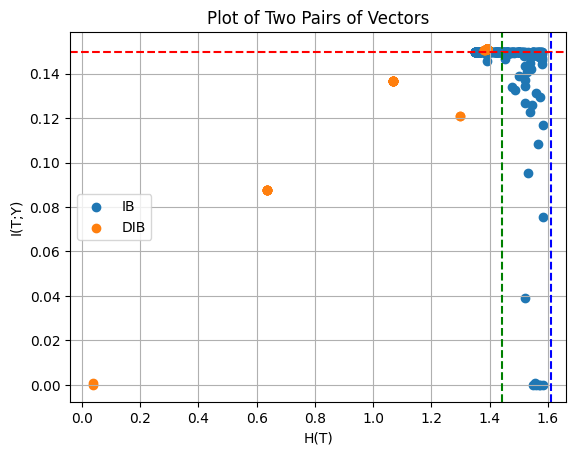

In [27]:
# Plot the first pair of vectors
plt.scatter(H_T_IB, I_TY_IB, label='IB')

# Plot the second pair of vectors
plt.scatter(H_T_DIB, I_TY_DIB, label='DIB')

# Add labels and title
plt.xlabel('H(T)')
plt.ylabel('I(T;Y)')
plt.title('Plot of Two Pairs of Vectors')

# Add horizontal line at I(X;Y)
I_XY = mutual_information(joint_prob)
plt.axhline(y=I_XY, color='r', linestyle='--')

# Add a vertical line at H(X) and log(|T|)
H_X = entropy(np.sum(joint_prob, axis=1))
log_T = np.log(joint_prob.shape[0])
plt.axvline(x=H_X, color='g', linestyle='--')
plt.axvline(x=log_T, color='b', linestyle='--')


# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()